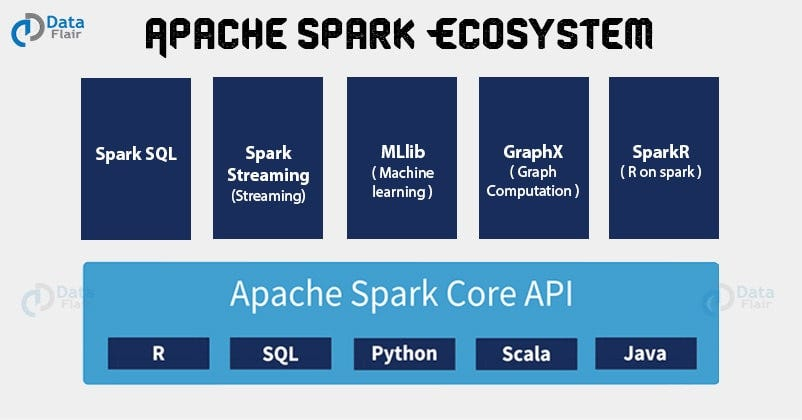

# __Инициализация библиотек__

In [32]:
from pyspark.sql import SparkSession
import pandas as pd
import pyspark.sql.functions as f

import time

# __Создание точки входа__

>Драйвер Spark является точкой входа в приложение Spark и используется для создания сеанса Spark

In [86]:
# для взаимодействия со spark API (точка вохода)
spark = SparkSession.builder.appName('Evgenii KS') \
                            .config("spark.memory.offHeap.enabled", "true") \
                            .config("spark.dynamicAllocation.enabled", "true") \
                            .getOrCreate()

|Функция/Метод|Описание|
|:-----|:-----|
|__.master("local")__|spark запускается в локальном режиме|
|__.config("spark.memory.offHeap.enabled", "true")__|память вне кучи может снизить накладные расходы JVM на сборку мусора|
|__.config("spark.dynamicAllocation.enabled", "true")__|включает или отключает динамическое распределение ресурсов|
|__.config("spark.driver.memory", "4g")__|объём памяти, выделенной для драйвера Spark|
|__.config("spark.executor.memory", "8g")__|объём памяти, выделенной для executor Spark|
|__.config("spark.executor.cores", 4)__|количество ядер CPU, используемых каждым executor|
|__.config("spark.executor.instances", 10)__|определяет кол-во executor на кластере|
|__.config("spark.default.parallelism", 100)__|количество разделов (partitions) по умолчанию для RDD|

# __Работа с структурой данных DataFrame через PySpark__

In [74]:
# 1-ый способ. Создаём spark dataframe из pandas dataframe
# df_pandas = pd.read_csv('/content/sample_data/california_housing_test.csv')
# df_spark = spark.createDataFrame(df_pandas)

start = time.time()

# 2-ой способ. Можно прочитать напрямую
# ОБРАТИТЕ ВНИМАНИЕ, что результат кэшируется .cache() - это вариант оптимизации, чтобы дальнейшие вычисления выполнялись быстрее
df_spark = spark.read.csv('/content/sample_data/california_housing_test.csv', header=True, inferSchema=True).cache()

# ИЛИ
# df_spark = spark.read \
#                 .option('header', True) \
#                 .option('inferSchema', True) \
#                 .csv('/content/sample_data/california_housing_test.csv') \
#                 .cache()

print(f"Кол-во партиций: {df_spark.rdd.getNumPartitions()}")
print(f'\nВремя выполнения {time.time()-start}\n')

Кол-во партиций: 1

Время выполнения 0.4924311637878418



In [4]:
df_spark.printSchema() # смотрим схему данных

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)



>__Для обработки данных можно использовать стандартные операторы DataFrame__

In [5]:
df_spark.select('longitude', 'latitude').show(5) # выбор колонок
df_spark.filter('latitude > 36').show(5) # фильтрация, метод filter работает быстрее чем другие методы
# df_spark.withColumn('relation', f.col('total_bedrooms')/f.col('total_rooms')).show(5) # создание новой колонки
df_spark.withColumn('relation', df_spark.total_bedrooms/df_spark.total_rooms).show(5) # создание новой колонки

+---------+--------+
|longitude|latitude|
+---------+--------+
|  -122.05|   37.37|
|   -118.3|   34.26|
|  -117.81|   33.78|
|  -118.36|   33.82|
|  -119.67|   36.33|
+---------+--------+
only showing top 5 rows
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -122.05|   37.37|              27.0|     3885.0|         661.0|    1537.0|     606.0|       6.6085|          344700.0|
|  -119.67|   36.33|              19.0|     1241.0|         244.0|     850.0|     237.0|       2.9375|           81700.0|
|  -119.56|   36.51|              37.0|     1018.0|         213.0|     663.0|     204.0|       1.6635|           67000.0|
|  -121.43|   38.63|              43.0|     1009.0|    

>__Также данные DataFrame можно обрабатывать через SQL операции (кому как удобно)__

In [ ]:
df_spark.createOrReplaceTempView('california_housing_test')
spark.sql('select * from california_housing_test where total_bedrooms > 700').show(5)
spark.sql('''
             select
                   housing_median_age
                  ,count(total_rooms) as total_rooms_cnt
             from california_housing_test
             group by housing_median_age
             having total_rooms_cnt > 50
          ''').show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -122.59|   38.01|              35.0|     8814.0|        1307.0|    3450.0|    1258.0|       6.1724|          414300.0|
|  -117.28|   33.28|              13.0|     6131.0|        1040.0|    4049.0|     940.0|       3.8156|          150700.0|
|  -122.42|   37.76|              52.0|     3587.0|        1030.0|    2259.0|     979.0|       2.5403|          250000.0|
|  -118.45|   34.07|              19.0|     4845.0|        1609.0|    3751.0|    1539.0|        1.583|          350000.0|
|  -118.48|   34.01|              30.0|     3078.0|         954.0|    1561.0|     901.0|       3.4852|          425000.0|
+---------+--------+----

# __Партицирование__

>Разделение данных в PySpark — это способ разбить большой набор данных на более мелкие на основе одного или нескольких ключей разделения.
>
>>__Разделение памяти__: Вы можете разделить или переразделить DataFrame, вызвав соответствующие функции repartition() или coalesce() преобразования.
>
>>__Разделение данных на диске__: При записи PySpark DataFrame обратно на диск вы можете выбрать способ разделения данных по столбцам, используя partitionBy()  соответствующий метод pyspark.sql.DataFrameWriter. Это аналогично схеме разделения данных в Hives.

In [65]:
# в качестве ключа партицирования буду использовать housing_median_age

# partitionBy() пример разделения данных на диске для ОДНОГО столбца (ключа)
# для каждого состояния (ключа) выделено по 1 разделу памяти (партиции)
df_spark.write.option("header",True) \
              .partitionBy("housing_median_age") \
              .mode("overwrite") \
              .csv("/content/sample_data/tmp/partitionBy-examples")

# partitionBy() пример разделения данных на диске для ДВУХ столбцов
# df_spark.write.option("header",True) \
#               .partitionBy("housing_median_age", "latitude") \
#               .mode("overwrite") \
#               .csv("/content/sample_data/tmp/partitionBy-examples")

>функция __repartition()__ увеличивает или уменьшает количество разделов, тогда как функция __coalesce()__ эффективно только уменьшает их число. ВАЖНО!!! Операции перераспределения данных (repartition() и coalesce()) в PySpark очень ресурсоемки.

In [73]:
# используем partitionBy() с repartition
# теперь у нас будет по 2 партиции для каждого ключа housing_median_age
# для каждого состояния (ключа) выделено по 2 раздела памяти (партиции)
df_spark.repartition(2) \
            .write.option("header",True) \
            .partitionBy("housing_median_age") \
            .mode("overwrite") \
            .csv("/content/sample_data/tmp/partitionBy-examples")

# print(f"Кол-во партиций: {df_spark.rdd.getNumPartitions}")

|Особенность|repartition|coalesce
|:-----|:-----|:-----|
|__Описание__|Изменяет количество разделов, перераспределяя данные по указанному числу разделов|Уменьшает количество разделов без перемешивания данных, объединяя существующие разделы
|__Полная перетасовка__|Да|Нет
|__Дороговизна__|Это может быть дорогостоящим процессом, особенно для больших наборов данных, поскольку он включает в себя полную перестановку данных|Это дешевле, чем перераспределение данных, поскольку минимизирует перемещение данных за счет объединения разделов только там, где это возможно
|__Перемещение данных__|Обеспечивает равномерное распределение данных по разделам, что потенциально может привести к сбалансированным размерам разделов|Это может привести к несбалансированным размерам разделов, особенно при уменьшении их количества
|__Варианты использования__|Полезно при изменении количества разделов или равномерном распределении данных по разделам|Это полезно при уменьшении количества разделов без необходимости полной перетасовки

In [56]:
# coalesce только уменьшает кол-во партиций в каждом ключе
df_spark.coalesce(4) \
        .write.option("header",True) \
        .partitionBy("housing_median_age") \
        .mode("overwrite") \
        .csv("/content/sample_data/tmp/partitionBy-examples")

__ЗАЧЕМ ЭТО НУЖНО?__

>Чтение данных после партицирования происходит значительно быстрее

In [45]:
start = time.time()

df_spark_with_partitions=spark.read.option("header",True) \
                                   .csv("/content/sample_data/tmp/partitionBy-examples").show(5)

print(f'\nВремя выполнения {time.time()-start}\n')

+---------+--------+-----------+--------------+----------+----------+-------------+------------------+------------------+
|longitude|latitude|total_rooms|total_bedrooms|population|households|median_income|median_house_value|housing_median_age|
+---------+--------+-----------+--------------+----------+----------+-------------+------------------+------------------+
|  -122.42|   37.79|     3364.0|        1100.0|    2112.0|    1045.0|       2.1343|          400000.0|              52.0|
|  -118.28|   33.73|     2085.0|         588.0|    1767.0|     516.0|       2.1935|          243200.0|              52.0|
|  -122.27|   37.82|     1630.0|         456.0|    1162.0|     400.0|       1.2475|          104200.0|              52.0|
|  -122.47|   37.75|     1598.0|         285.0|     689.0|     265.0|       4.6071|          337400.0|              52.0|
|  -118.28|   34.09|     1739.0|         464.0|     938.0|     482.0|       2.4429|          228800.0|              52.0|
+---------+--------+----

__Можно прочитать определённые партиции__

In [43]:
start = time.time()

df_column = 'housing_median_age=1.0' # фильтр по партиции


df_spark_with_partitions=spark.read.option("header",True) \
                                   .csv(f"/content/sample_data/tmp/partitionBy-examples/{df_column}").show()

print(f'\nВремя выполнения {time.time()-start}\n')

+---------+--------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+-----------+--------------+----------+----------+-------------+------------------+
|  -116.95|   33.86|        6.0|           2.0|       8.0|       2.0|        1.625|           55000.0|
|  -117.95|   35.08|       83.0|          15.0|      32.0|      15.0|        4.875|          141700.0|
+---------+--------+-----------+--------------+----------+----------+-------------+------------------+


Время выполнения 0.3569962978363037



__Можно прочитать определённые партиции ЧЕРЕЗ SQL__

In [42]:
start = time.time()

df_spark_with_partitions=spark.read.option("header",True) \
                                   .csv(f"/content/sample_data/tmp/partitionBy-examples")

df_spark_with_partitions.createOrReplaceTempView('df_spark_with_partitions')
spark.sql('select * from df_spark_with_partitions where housing_median_age=1.0').show(5)

print(f'\nВремя выполнения {time.time()-start}\n')

+---------+--------+-----------+--------------+----------+----------+-------------+------------------+------------------+
|longitude|latitude|total_rooms|total_bedrooms|population|households|median_income|median_house_value|housing_median_age|
+---------+--------+-----------+--------------+----------+----------+-------------+------------------+------------------+
|  -116.95|   33.86|        6.0|           2.0|       8.0|       2.0|        1.625|           55000.0|               1.0|
|  -117.95|   35.08|       83.0|          15.0|      32.0|      15.0|        4.875|          141700.0|               1.0|
+---------+--------+-----------+--------------+----------+----------+-------------+------------------+------------------+


Время выполнения 2.468409299850464



__Практический пример__

In [83]:
df_new = df_spark.repartition(2, 'housing_median_age').cache()
df_new.groupBy('housing_median_age').count().show()

+------------------+-----+
|housing_median_age|count|
+------------------+-----+
|              27.0|   74|
|              19.0|   76|
|              31.0|   57|
|              45.0|   51|
|              36.0|  115|
|              16.0|  107|
|              42.0|   51|
|              35.0|  118|
|              13.0|   41|
|              32.0|   91|
|              14.0|   57|
|              17.0|  100|
|              38.0|   64|
|              33.0|   85|
|               4.0|   28|
|               6.0|   25|
|              39.0|   55|
|              12.0|   41|
|              22.0|   60|
|              46.0|   41|
+------------------+-----+
only showing top 20 rows


# __Broadcast и Shuffle join__

>__Broadcast__ метод идеально подходит для объединения большого DataFrame с меньшим

In [82]:
from pyspark.sql.functions import broadcast

# применение broadcast это также один из способов оптимизации
df_spark.join(broadcast(df_spark.limit(10)), how="left", on="total_bedrooms").show()

# ИЛИ
# df_spark.join(df_spark.limit(10).hint("broadcast"), "total_bedrooms").show()

+--------------+---------+--------+------------------+-----------+----------+----------+-------------+------------------+---------+--------+------------------+-----------+----------+----------+-------------+------------------+
|total_bedrooms|longitude|latitude|housing_median_age|total_rooms|population|households|median_income|median_house_value|longitude|latitude|housing_median_age|total_rooms|population|households|median_income|median_house_value|
+--------------+---------+--------+------------------+-----------+----------+----------+-------------+------------------+---------+--------+------------------+-----------+----------+----------+-------------+------------------+
|         661.0|  -122.05|   37.37|              27.0|     3885.0|    1537.0|     606.0|       6.6085|          344700.0|  -122.05|   37.37|              27.0|     3885.0|    1537.0|     606.0|       6.6085|          344700.0|
|         310.0|   -118.3|   34.26|              43.0|     1510.0|     809.0|     277.0|    

# __UDF функции__

>Использование пользовательских функций (UDF) — наиболее ресурсоемкая операция, поэтому используйте их только при наличии крайней необходимости.

>>PySpark UDF — это определяемая пользователем функция, используемая для создания многократно используемых функций в Spark.
>
>>После создания пользовательской функции (UDF) её можно повторно использовать в нескольких DataFrames и SQL-запросах (после регистрации).
>
>>Тип данных по умолчанию для функции udf() — StringType.
>
>>Необходимо явно обрабатывать значения null, иначе возникнут побочные эффекты.

>__1-й способ создания__

In [12]:
from pyspark.sql.functions import col, udf

# сначала создаём стандартную Python функцию
def udf_func(x):
  return x*2

# оборачиваем нашу функцию в udf
convertUDF = udf(lambda z: udf_func(z))

# применеям к DataFrame
df_spark.select(col('population'), convertUDF(col('population'))).show(5)
# или
df_spark.withColumn('population_new', convertUDF(col('population'))).show(5)


# применеям к DataFrame через SQL
spark.udf.register('convertUDF', udf_func)
df_spark.createOrReplaceTempView('california_housing_test_tmp')
spark.sql('''
          select
               population
              ,convertUDF(population) as 2_population
          from california_housing_test_tmp
          ''').show(2)


+----------+--------------------+
|population|<lambda>(population)|
+----------+--------------------+
|    1537.0|              3074.0|
|     809.0|              1618.0|
|    1484.0|              2968.0|
|      49.0|                98.0|
|     850.0|              1700.0|
+----------+--------------------+
only showing top 5 rows
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|population_new|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------+
|  -122.05|   37.37|              27.0|     3885.0|         661.0|    1537.0|     606.0|       6.6085|          344700.0|        3074.0|
|   -118.3|   34.26|              43.0|     1510.0|         310.0|     809.0|     277.0|        3.599|          176500.0| 

>__2-й способ создания__

In [13]:
# используя декоратор
from pyspark.sql.functions import col, udf

# сначала создаём стандартную Python функцию
@udf
def udf_func(x):
  return x*2

# применеям к DataFrame
df_spark.select(col('population'), udf_func(col('population'))).show(5)
# или
df_spark.withColumn('population_new', udf_func(col('population'))).show(5)

+----------+--------------------+
|population|udf_func(population)|
+----------+--------------------+
|    1537.0|              3074.0|
|     809.0|              1618.0|
|    1484.0|              2968.0|
|      49.0|                98.0|
|     850.0|              1700.0|
+----------+--------------------+
only showing top 5 rows
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|population_new|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------+
|  -122.05|   37.37|              27.0|     3885.0|         661.0|    1537.0|     606.0|       6.6085|          344700.0|        3074.0|
|   -118.3|   34.26|              43.0|     1510.0|         310.0|     809.0|     277.0|        3.599|          176500.0| 

# __Метод transform() для последовательного выполнения пользовательских преобразований__

In [100]:
# трансформация 1
def task1(df):
  return df.withColumn("task1", df.total_rooms / df.total_bedrooms)

# трансформация 2
def task2(df):
  return df.withColumn("task2", df.population / 100)

# трансформация 3
def task3(df):
  return df.withColumn("task3", df.total_rooms - df.total_bedrooms)

df_spark.transform(task1) \
        .transform(task2) \
        .transform(task3).show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+------------------+-----+------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|             task1|task2| task3|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+------------------+-----+------+
|  -122.05|   37.37|              27.0|     3885.0|         661.0|    1537.0|     606.0|       6.6085|          344700.0| 5.877458396369137|15.37|3224.0|
|   -118.3|   34.26|              43.0|     1510.0|         310.0|     809.0|     277.0|        3.599|          176500.0| 4.870967741935484| 8.09|1200.0|
|  -117.81|   33.78|              27.0|     3589.0|         507.0|    1484.0|     495.0|       5.7934|          270500.0|7.0788954635108485|14.84|3082.0|
|  -118.36|   33.82|              28.0|       67.0|          15.0|      49.0

# __Ссылки на полезные источники__

>https://github.com/spark-examples/pyspark-examples/blob/master/


>https://sparkbyexamples.com/pyspark-tutorial/